#A) Introduction

## This exercise is to build a predictive model to predict the likelihood of an individual's next credit card payment get defaulted or by using the attributes.

#### The dataset is downloaded from https://archive-beta.ics.uci.edu/ml/datasets/default+of+credit+card+clients#Descriptive. 


#### There are 27 variables and one target variable - "default payment next month" 

#### The attributes are credit limit, gender, eduation, marital status, age, history of past payment for 6 months, amount of bill payments for 6 months and amount paid for 6 months. 


#### Each row represents each individual.


#### Dataset description:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

X4: Marital status (1 = married; 2 = single; 3 = others)

X5: Age (year)

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

# B) Load the data

In [1]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.
# Tesla K80: 30
# Tesla P100: 60
# Tesla T4: 75v
%env compute_capability=75v

env: compute_capability=75v


In [4]:
%cd ..
from google.colab import drive
#drive.flush_and_unmount()

drive.mount('/content/drive')

/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

from statsmodels.stats.multitest import multipletests
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from tensorflow import keras


from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,plot_roc_curve
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
%cd '/content/drive/My Drive/Interview/Credit Sesame/'
%ls

/content/drive/My Drive/Interview/Credit Sesame
'Data Scientist Take Home.pdf'          gitCommands.ipynb
'default of credit card clients.xls'   'Take Home Assessment.ipynb'
'default of credit card clients.xlsx'  'Take_Home_Assessment_old .ipynb'


In [7]:
data=pd.read_excel('default of credit card clients.xlsx',header=1,index_col='ID')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Dataset

In [8]:
row, att=data.shape
print(f"Number of individual in the dataset: {row}")
print(f"Number of attributes in the dataset: {att}")

Number of individual in the dataset: 30000
Number of attributes in the dataset: 24


In [9]:
columns_name=data.columns

print(f"These are the columns name: {columns_name.values}")

These are the columns name: ['LIMIT_BAL' 'SEX' 'EDUCATION' 'MARRIAGE' 'AGE' 'PAY_0' 'PAY_2' 'PAY_3'
 'PAY_4' 'PAY_5' 'PAY_6' 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3' 'BILL_AMT4'
 'BILL_AMT5' 'BILL_AMT6' 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4'
 'PAY_AMT5' 'PAY_AMT6' 'default payment next month']


#C)Data Cleaning

#### 1) Check Typo in header

In [10]:
data = data.rename(columns={'PAY_0': 'PAY_1'})

There is a typo in PAY_0 column and it should be PAY_1


In [11]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

#### 2) Check missing data

In [12]:
data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

There is no missing data. 

#### 3) Check data type

In [13]:
data.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_1                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

All data are numeric

#### 4) Understand the numerical features

In [14]:

numerical_features = [
    'LIMIT_BAL', 'AGE', 'BILL_AMT1', 
    'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 
    'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
    'PAY_AMT5', 'PAY_AMT6'
    ]


###### Check if there is any abnormal in the numerical data

In [15]:
data[numerical_features].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Nothing is abnormal for numerical data.

#### 5) Understand Categorical data

##### Check data typo / consistency

In [16]:
categorical_features = [
    'SEX','EDUCATION','MARRIAGE',
    'PAY_1','PAY_2','PAY_3',
    'PAY_4','PAY_5','PAY_6',
    'default payment next month'
    ]

In [17]:
data[categorical_features].count()

SEX                           30000
EDUCATION                     30000
MARRIAGE                      30000
PAY_1                         30000
PAY_2                         30000
PAY_3                         30000
PAY_4                         30000
PAY_5                         30000
PAY_6                         30000
default payment next month    30000
dtype: int64

In [18]:
data[categorical_features].count()
data[categorical_features].min()

SEX                           1
EDUCATION                     0
MARRIAGE                      0
PAY_1                        -2
PAY_2                        -2
PAY_3                        -2
PAY_4                        -2
PAY_5                        -2
PAY_6                        -2
default payment next month    0
dtype: int64

In [19]:
data[categorical_features].max()

SEX                           2
EDUCATION                     6
MARRIAGE                      3
PAY_1                         8
PAY_2                         8
PAY_3                         8
PAY_4                         8
PAY_5                         8
PAY_6                         8
default payment next month    1
dtype: int64

In [20]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

#### Oberservation:

1) According to the description of the data set, marriage should start with 1 not 0, so there are typos for all the marriage = 0. In that case, we categorize these rows as "Others" since we do not know the true value.

2) Education should start at 1 not 0 and there is no category as "5,6". That's why we regroup those entries = 0,5,6 into 4 "Others". 

3) PAY columns should start -1 but not -2. 


##### Fix marriage and education data

In [21]:
# Fixing marriage
data['MARRIAGE'] = data['MARRIAGE'].apply(lambda x: 3 if x == 0 else x)

# Fixing education
data['EDUCATION'] = data['EDUCATION'].apply(lambda x: 4 if x in [0, 5, 6] else x)

#### Fix PAY columns

After understanding the PAY columns by investigating the balance using Pay_amount columns and Bill_amount columns, we can assume -1 value for PAY columns represent paid in full amount, -2 value represents the bill is paid in full that particular month or with positive balance and 0 value represents the bill is paid at the miniumum. 

In order to make the analysis easier, we can group -2 to -1 as well. 

In [22]:
# Fixing PAY Columns with value -2

pay_cols = ['PAY_{}'.format(x) for x in range(1,7)]
for col in pay_cols:
  data[col] = data[col].apply(lambda x: -1 if x in [-1,-2] else x)


## 2) Data Exploration

### I) Target value distribution and graphs

Column: default payment next month represents the account get defaulted the next month or not

Class 0 means not defaulted

Class 1 means defaulted

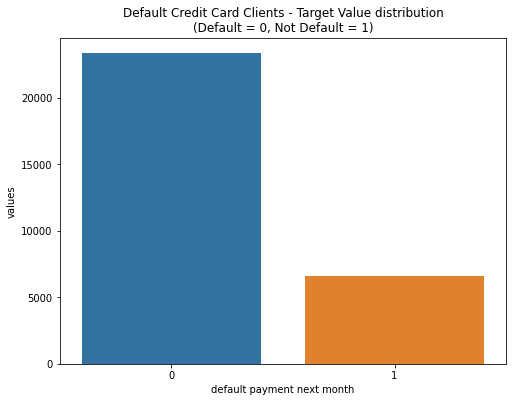

In [23]:
plt.figure(figsize = (8,6))
target_count = data["default payment next month"].value_counts()
target_count = pd.DataFrame({'default payment next month': target_count.index,'values': target_count.values})
plt.title('Default Credit Card Clients - Target Value distribution\n(Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default payment next month', y="values", data=target_count)
locs, labels = plt.xticks()
plt.show()

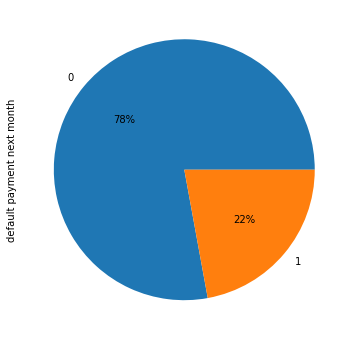

In [24]:
plt.figure(figsize = (8,6))
pd.value_counts(data['default payment next month']).plot(kind='pie', y='default.payment.next.month', autopct='%1.0f%%');

In [25]:
target_count['count in %']=target_count['values']/len(data)*100
target_count

,default payment next month,values,count in %
0,0,23364,77.88
1,1,6636,22.12


Majority of the target class data are not belonged to the class not defaulted (class 0) and only 22% of the target data are belonged to defaulted (class 1). In this case, this is an unbalanced dataset. In data preparation / preprocessing part, we will need to resample them to make it more balanced. 

### II) Credit limit 

Column name "LIMIT_BAL" represents the Amount of the given credit in (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

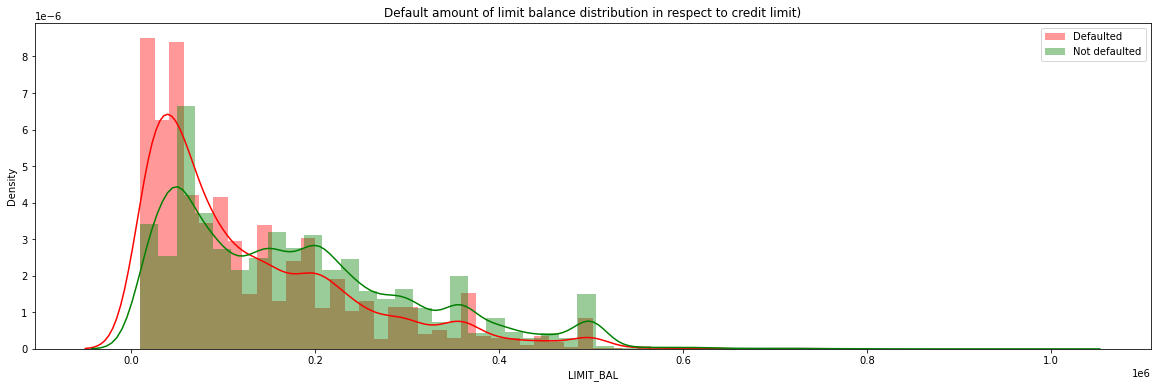

In [26]:
class_0=data[data['default payment next month']==0]['LIMIT_BAL']
class_1=data[data['default payment next month']==1]['LIMIT_BAL']

plt.figure(figsize = (20,6))
plt.title('Default amount of limit balance distribution in respect to credit limit)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True, color="red",label="Defaulted")
sns.distplot(class_0,kde=True,color="green",label="Not defaulted")
plt.legend()
plt.show()

In the graph above, we can see that the majority of the defaulted account has the limit balance from 0.0 to 0.2 in millions and those one in green are the one not defaulted and they are distributed evenly.

##### Correlation Test

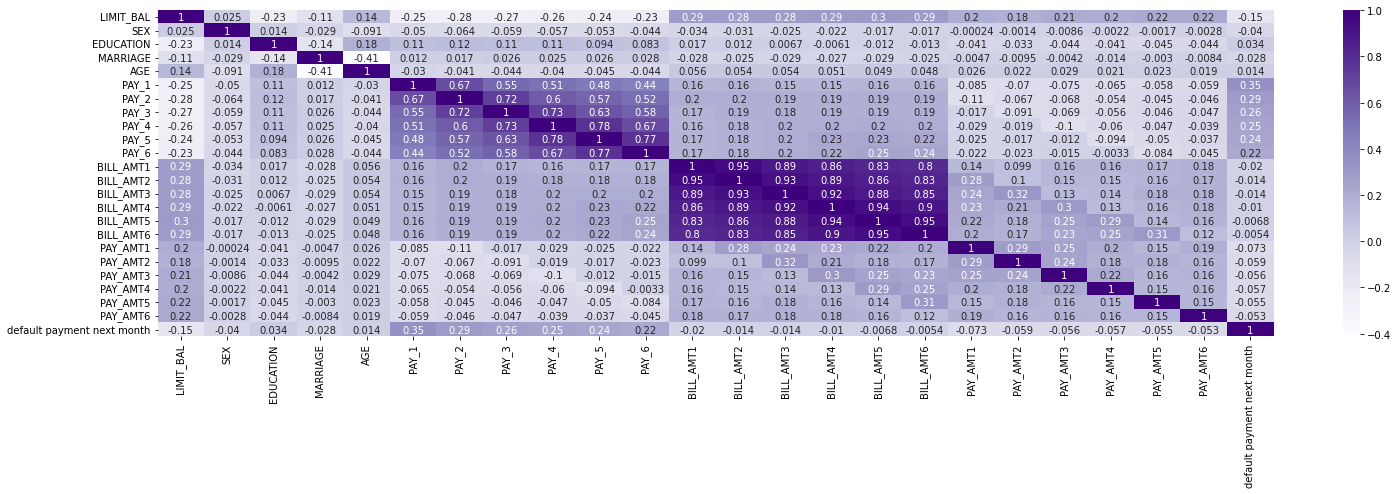

In [27]:
plt.figure(figsize = (25,6))

corr = data.corr()
sns.heatmap(corr, cmap="Purples", annot=True)
plt.show()

As a preliminary correlation study, LIMIT_BAL are not correlated with 'defaulted payment next month' column strongly, so we can not draw an conclusion for the relationship between majority of defaulted class have low limit balance. 

### III) Sex vs Default

Sex Column: Gender (1 = male; 2 = female).

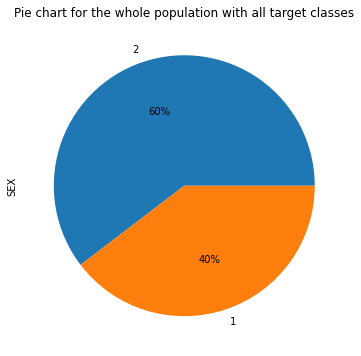

In [28]:
plt.figure(figsize = (8,6))
pd.value_counts(data['SEX']).plot(kind='pie', y='SEX', autopct='%1.0f%%')
plt.title('Pie chart for the whole population with all target classes')
plt.show()

In this dataset, 60% of the accounts are belonged to female and 40% are belonged to male. It might cause an imbalanced dataset in term of gender class.

<Figure size 576x432 with 0 Axes>

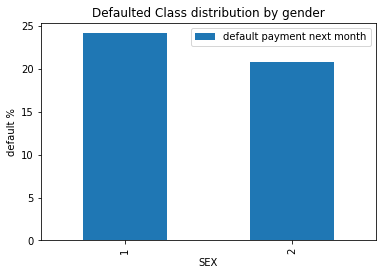

In [29]:
plt.figure(figsize = (8,6))
val_counts = data.groupby('SEX')['default payment next month'].apply(lambda group: group.value_counts()/len(group)*100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')
plt.title("Defaulted Class distribution by gender")
plt.show()


For those defaulted, around 25% are male and 20% are female.

In [30]:
val_counts = data.groupby('SEX')['default payment next month'].apply(lambda group: group.value_counts()/len(group)*100)
pd.DataFrame(val_counts)

default payment next month
SEX                              
1   0                   75.832773
    1                   24.167227
2   0                   79.223719
    1                   20.776281

The ratio of default to not default for male is the same as female.

#### Correlation Test

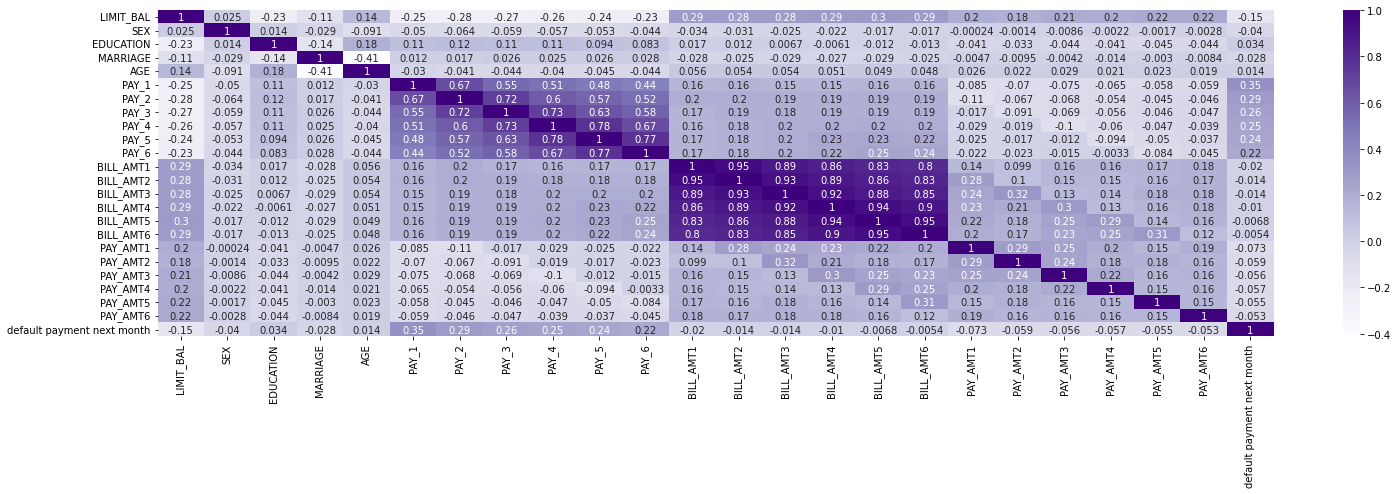

In [31]:
plt.figure(figsize = (25,6))

corr = data.corr()
sns.heatmap(corr, cmap="Purples", annot=True)
plt.show()

In the table, gender "SEX" column does not have high correlation with the target column "Default payment next month", so the imbalance class in gender might not cause a problem in the predictive model.

### IV) Education

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

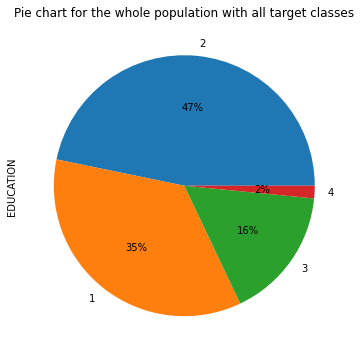

In [32]:
plt.figure(figsize = (8,6))
pd.value_counts(data['EDUCATION']).plot(kind='pie',y='EDUCATION', autopct='%1.0f%%')
plt.title('Pie chart for the whole population with all target classes')
plt.show()

<Figure size 576x432 with 0 Axes>

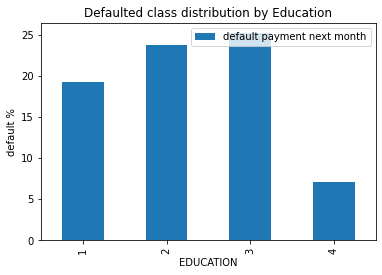

In [33]:
plt.figure(figsize = (8,6))
val_counts = data.groupby('EDUCATION')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')
plt.title('Defaulted class distribution by Education')

plt.show()

Majority of the defaulted class are in education 2 and 3 but education class 4 has the lowest default rate. The second lowest is education 1 - graduate school education.

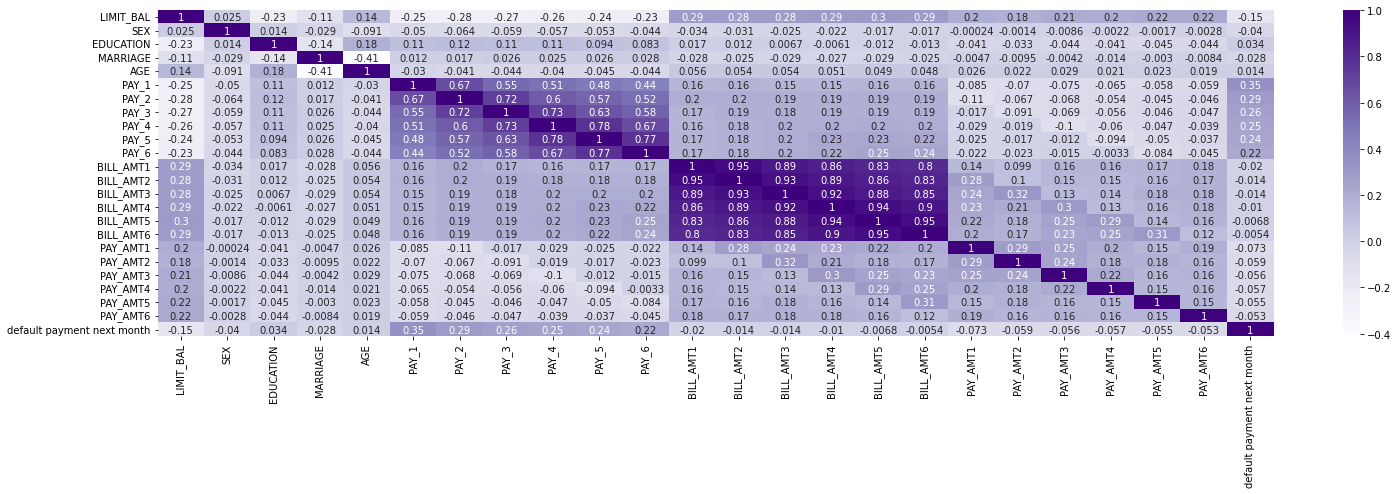

In [34]:
plt.figure(figsize = (25,6))

corr = data.corr()
sns.heatmap(corr, cmap="Purples", annot=True)
plt.show()

## V) AGE

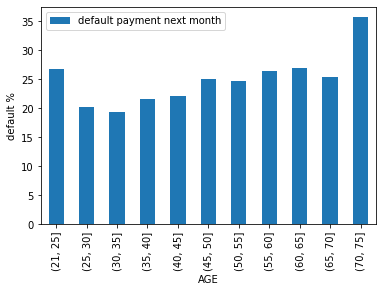

In [35]:
bin_data=data.copy()
age_bins = [data['AGE'].min(), 25,30,35,40,45,50,55,60,65,70,75,data['AGE'].max()]
bin_data['AGE']=pd.cut(data['AGE'], age_bins)

val_counts = bin_data.groupby('AGE')['default payment next month'].apply(lambda group: group.value_counts()/ len(group)*100)

val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

plt.show()


### VI) Payment 

### Frequency

#### Number of paid on time Vs Default rate

Add a column into dataset called "Number_of_paid_on_time"

In [36]:
# Number of paid on time per individual
pay_cols = ['PAY_{}'.format(x) for x in range(1,7)]
pay_cols = data[pay_cols]
for PAY_col in pay_cols:
  pay_cols[PAY_col]=pay_cols[PAY_col].apply(lambda x:1 if x in [-2,-1,0] else 0)
data['Number_of_paid_on_time']=pay_cols.sum(axis=1)
numerical_features.append('Number_of_paid_on_time')

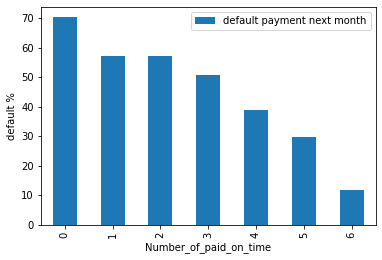

In [37]:
val_counts = data.groupby('Number_of_paid_on_time')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

#### Number of times the payment has been delayed - Frequency

Add a column for number of time payment delayed

In [38]:
# Number of time the payment has been delayed per individual
pay_cols = ['PAY_{}'.format(x) for x in range(1,7)]
pay_cols = data[pay_cols]
for PAY_col in pay_cols:
  pay_cols[PAY_col]=pay_cols[PAY_col].apply(lambda x:1 if x not in [-2,-1,0] else 0)
data['Number_of_times_delayed']=pay_cols.sum(axis=1)
numerical_features.append('Number_of_times_delayed')

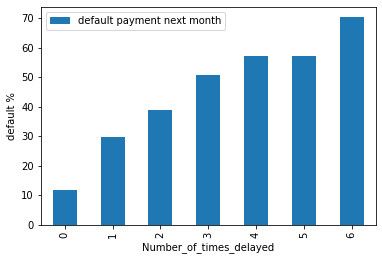

In [39]:
val_counts = data.groupby('Number_of_times_delayed')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

### Recency

#### Most recent delayed payment

Add a column for the recency 

In [40]:
pay_cols = ['PAY_{}'.format(x) for x in range(6, 1, -1)]
pay_cols = data[pay_cols]
most_recent_index=[]

for i in range(len(pay_cols)):
  recent_index=np.argwhere(pay_cols.iloc[i,:].values >0)

  if  recent_index.size==0:
    most_recent_index.append(0)
  else:
    most_recent_index.append(recent_index.min()+1)
  


In [41]:
data['most_recent_month_delayed']=most_recent_index
numerical_features.append('most_recent_month_delayed')

### Monetary 

Add a column for outstanding balance (bill - amount paid) accumlatively for last 6 months

In [42]:
bill_cols = ['BILL_AMT{}'.format(x) for x in range(1,7)]
pay_amount_cols = ['PAY_AMT{}'.format(x) for x in range(1,7)]

outstandings_data = data[bill_cols+pay_amount_cols]
outstandings_data=outstandings_data.reset_index()

outstandings_amount_list=[]
for i in range(len(outstandings_data)):
  # print(i)
  total_amount=0
  for ix,(b, p) in enumerate(zip(bill_cols,pay_amount_cols)):
      # print(b,p)
      amount=outstandings_data[str(b)][i]-outstandings_data[str(p)][i]
      total_amount+=amount
  outstandings_amount_list.append(total_amount)

data['Outstanding_total_amount']=outstandings_amount_list

  

numerical_features.append('Outstanding_total_amount')

In [43]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-1,...,689,0,0,0,0,1,4,2,5,7015
2,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,1,4,2,1,12077
3,90000,2,2,2,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,6,0,0,90635
4,50000,2,2,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,6,0,0,222946
5,50000,1,2,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,6,0,0,50290


## C) Data Preprocessing / Preparation

### I) Set target value , features values


In [44]:
y=data['default payment next month']
X=data.drop(columns=['default payment next month'],axis=1)


### II) Resample data due to imbalance dataset

In this dataset, the class 0 is significantly outnumbered the class 1. It might cause the bias situation in the model. 

The technique that we can use is to either undersample class 0 or oversample class 1.

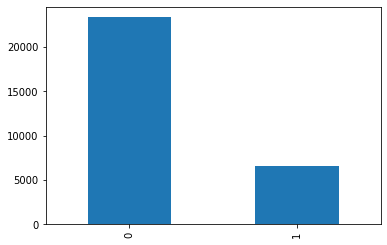

In [45]:
pd.value_counts(y).plot(kind='bar')
plt.show()

In [46]:
sm = SMOTE(random_state=42)
X_new, y_new = sm.fit_resample(X, y)

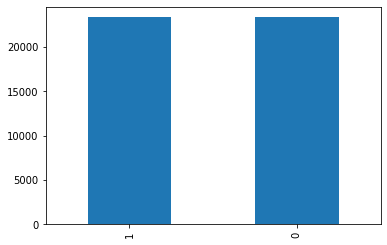

In [47]:
pd.value_counts(y_new).plot(kind='bar')
plt.show()

### III) Data split - Train , test set

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=0.2, random_state=5)

<!-- ### V) Scale the numerical columns by using min_max scaler for both X_train, X_test -->

### IV) Scale Data

In [49]:
numerical_features

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'Number_of_paid_on_time',
 'Number_of_times_delayed',
 'most_recent_month_delayed',
 'Outstanding_total_amount']

In [50]:
numerical_convert=[
    'LIMIT_BAL','AGE','Outstanding_total_amount'
    ]

In [51]:

MM = MinMaxScaler()
X_train[numerical_convert]=MM.fit_transform(X_train[numerical_convert])
X_test[numerical_convert]=MM.transform(X_test[numerical_convert])

In [52]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
7186,0.232323,2,1,1,0.241379,-1,-1,0,-1,0,...,10420,1150,5928,3619,13227,7764,6,0,0,0.394093
33581,0.021809,2,2,1,0.517241,2,2,2,2,2,...,1247,1584,111,1440,0,843,0,6,1,0.407127
17334,0.494949,2,1,1,0.275862,1,-1,-1,-1,-1,...,2529,2971,200,38144,0,8479,5,1,0,0.401111
8144,0.040404,1,1,2,0.034483,0,0,2,2,0,...,3600,1400,0,1200,2000,1000,4,2,3,0.408034
31646,0.020202,1,2,2,0.086207,6,5,4,3,2,...,0,7,0,0,985,1018,0,5,1,0.420846


In [53]:
X_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
12621,0.222222,2,3,1,0.155172,0,0,0,0,0,...,7214,6264,10000,5028,5000,5000,6,0,0,0.528706
37856,0.070579,1,2,1,0.275862,0,0,0,-1,-1,...,1010,0,0,0,0,0,6,0,0,0.400852
18436,0.070707,2,4,2,0.068966,0,0,0,0,0,...,1500,2000,1000,0,0,0,6,0,0,0.396866
295,0.191919,1,1,2,0.172414,0,0,0,0,0,...,9000,7465,4715,4804,5141,5300,6,0,0,0.532449
9443,0.141414,1,1,2,0.172414,-1,-1,-1,-1,0,...,0,601,4102,0,2019,5515,6,0,0,0.394438


# D) Model Selection 

### I) Use GridSearch to find the best performance models

There are a few classifiers widely used for classification problem. Below is the performance result in accuracy 


1) XGBoost

2) Random Forest Classifier

3) Logistic Regression

4) KN Neighbors

5) Neural Network

In [54]:
def test(models, X_train, y_train, X_test, y_test, iterations = 25):
    accuracy_results = {}
    for i in models:
        accuracy_train = []
        accuracy_test = []
        for j in range(iterations):

            accuracy_test.append(accuracy_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            accuracy_train.append(accuracy_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
            
        accuracy_results[i] = [np.mean(accuracy_train), np.mean(accuracy_test)]
    return pd.DataFrame(accuracy_results)

In [55]:
xgb_params = {
    'model__n_estimators': [5,10],
    'model__max_depth': [3,6],
    'model__learning_rate': [0.1, 0.20]}

rf_params = {
    'max_depth': [5,10, 20],
    'min_samples_leaf': [3,5],
    'class_weight': ['balanced']
}
logistic_params = {
    'C': [0.05,0.1],

}



In [56]:
models2 = {
    'xgb': GridSearchCV(xgb.XGBClassifier(),
                             param_grid=xgb_params).fit(X_train, y_train).best_estimator_,
    'RandomF': GridSearchCV(RandomForestClassifier(), 
                               param_grid=rf_params).fit(X_train, y_train).best_estimator_,
    'logistic': GridSearchCV(LogisticRegression(), 
                               param_grid=logistic_params).fit(X_train, y_train).best_estimator_,
           }

In [57]:
test(models2, X_train, y_train, X_test, y_test)

,xgb,RandomF,logistic
0,0.823739,0.951985,0.673292
1,0.815108,0.846086,0.662957


In [58]:
models2

{'xgb': XGBClassifier(model__learning_rate=0.1, model__max_depth=3,
               model__n_estimators=5),
 'RandomF': RandomForestClassifier(class_weight='balanced', max_depth=20,
                        min_samples_leaf=3),
 'logistic': LogisticRegression(C=0.05)}

#### 2) Model Evaluation 

#### I) XGB:

In [59]:
y_pred_xgb=models2['xgb'].predict(X_test)

In [60]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4650
           1       0.86      0.76      0.80      4696

    accuracy                           0.82      9346
   macro avg       0.82      0.82      0.81      9346
weighted avg       0.82      0.82      0.81      9346



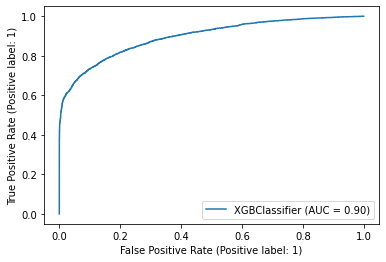

In [61]:
plot_roc_curve(models2['xgb'], X_test, y_test)

#### II) Random Forest

In [62]:
y_pred_rf=models2['RandomF'].predict(X_test)

In [63]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4650
           1       0.88      0.80      0.84      4696

    accuracy                           0.85      9346
   macro avg       0.85      0.85      0.85      9346
weighted avg       0.85      0.85      0.85      9346



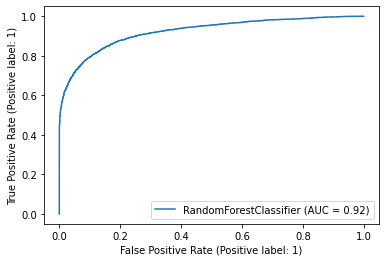

In [64]:
plot_roc_curve(models2['RandomF'], X_test, y_test)

#### III) Logistic Regression

In [65]:
y_pred_logistic=models2['logistic'].predict_proba(X_test)
y_pred_logistic=y_pred_logistic[:,1]

In [66]:
# keep probabilities of the positive class only
y_pred_log_class=[]
for prob in y_pred_logistic:
  if prob <0.5:
    y_pred_log_class.append(0)
  else:
    y_pred_log_class.append(1)

In [67]:
print(classification_report(y_test, y_pred_log_class))

              precision    recall  f1-score   support

           0       0.61      0.86      0.72      4650
           1       0.77      0.47      0.58      4696

    accuracy                           0.66      9346
   macro avg       0.69      0.66      0.65      9346
weighted avg       0.69      0.66      0.65      9346



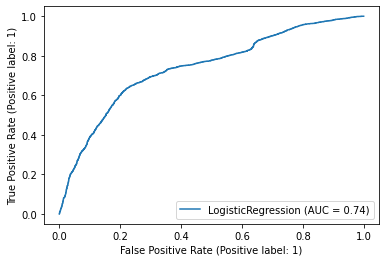

In [68]:
plot_roc_curve(models2['logistic'], X_test, y_test)

#### IV) Neural Network - DNN

In [69]:
attribute_len=len(X_train.columns)

In [70]:
model = keras.Sequential([
    keras.layers.Dense(9, input_shape=(attribute_len,), activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50)

Epoch 1/20
1169/1169 [==============================] - 2s 1ms/step - loss: 88.3879 - accuracy: 0.5029
Epoch 2/20
1169/1169 [==============================] - 2s 1ms/step - loss: 1.3915 - accuracy: 0.5003
Epoch 3/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.8170 - accuracy: 0.5006
Epoch 4/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.8032 - accuracy: 0.5010
Epoch 5/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.7383 - accuracy: 0.5024
Epoch 6/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.6945 - accuracy: 0.4994
Epoch 7/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.6978 - accuracy: 0.5019
Epoch 8/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.4976
Epoch 9/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.6948 - accuracy: 0.4979
Epoch 10/20
1169/1169 [==============================] - 2s 1ms/step - loss: 0.69

In [71]:
model.evaluate(X_test, y_test)

293/293 [==============================] - 0s 982us/step - loss: 0.6932 - accuracy: 0.5025


[0.6931872367858887, 0.5024609565734863]

In [72]:
y_pred_prob = model.predict(X_test)
y_pred_prob=[np.around(item,decimals = 2) for item in y_pred_prob]

In [73]:
y_pred=[]

for element in y_pred_prob:
    if element >= 0 and element <0.5:
        y_pred.append(0)
    elif element >=0.5 and element <=1:
        y_pred.append(1)

    

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4650
           1       0.50      1.00      0.67      4696

    accuracy                           0.50      9346
   macro avg       0.25      0.50      0.33      9346
weighted avg       0.25      0.50      0.34      9346



### Conclusion: Among all these models, Random Forest performs the best

In [77]:
models2['RandomF']

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3)

# F) Construct the predictive Model

### I) Find out the optimal number of features to select

In [78]:
selected_model=models2['RandomF']

In [79]:
hyper_params=[{'n_features_to_select':[5,10,15,20,24]}]

In [80]:
rfe=RFE(selected_model)

In [81]:
modelcv=GridSearchCV(estimator=rfe,param_grid = hyper_params, scoring='accuracy', verbose=1, return_train_score=True)

In [82]:
modelcv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RFE(estimator=RandomForestClassifier(class_weight='balanced',
                                                            max_depth=20,
                                                            min_samples_leaf=3)),
             param_grid=[{'n_features_to_select': [3, 5, 10, 15, 20, 24]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [84]:
cvresults=pd.DataFrame(modelcv.cv_results_)

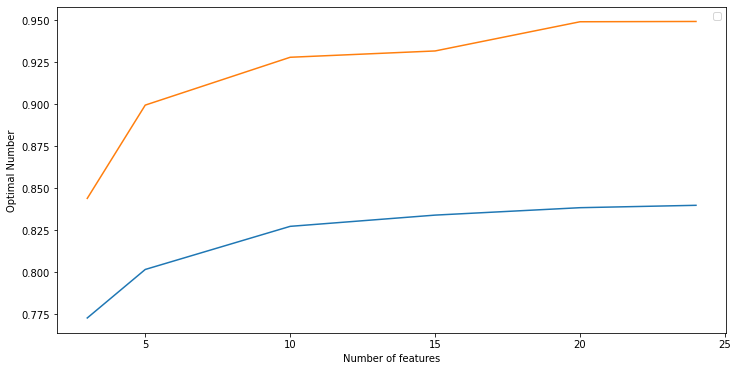

In [85]:
plt.figure(figsize=(12,6))
x_ticks = [5, 10, 15, 20, 25]

plt.xticks(ticks=x_ticks)
plt.plot(cvresults['param_n_features_to_select'], cvresults['mean_test_score'])

#plotting the mean train cvresults
plt.plot(cvresults['param_n_features_to_select'], cvresults['mean_train_score'])

plt.xlabel('Number of features')
plt.ylabel('Optimal Number')
plt.legend()
plt.show()

The optimal number of features is around 20. 

### 2) Find the Feature Importance

In [102]:
importances = selected_model.feature_importances_
pd.DataFrame([X_train.columns,importances]).T.sort_values(by=[1],ascending=False)

,0,1
23,Number_of_paid_on_time,0.232545
24,Number_of_times_delayed,0.061531
25,most_recent_month_delayed,0.04786
5,PAY_1,0.04608
11,BILL_AMT1,0.037762
26,Outstanding_total_amount,0.034083
17,PAY_AMT1,0.033453
0,LIMIT_BAL,0.032611
12,BILL_AMT2,0.031397
18,PAY_AMT2,0.031025


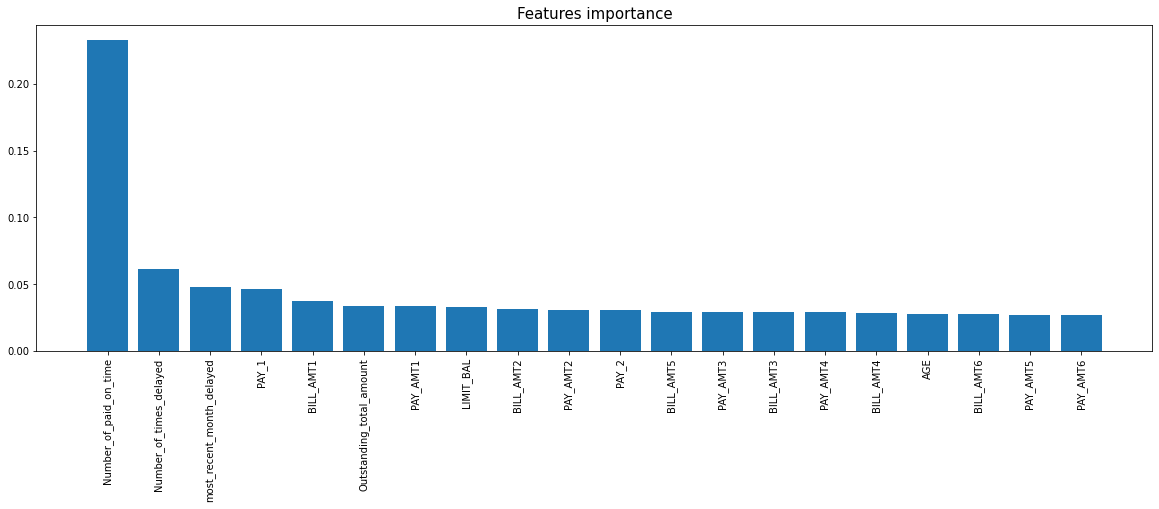

In [99]:
feature_importance_df = pd.DataFrame({'Feature_name': X_train.columns, 'Importance': selected_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (20, 6))
plt.title('Features importance', fontsize=15)
ax = plt.bar(feature_importance_df['Feature_name'][:24], feature_importance_df['Importance'][:24])
plt.xticks(rotation=90)
plt.show() 


### 3) Select Feature

In [108]:
selected_row=feature_importance_df['Feature_name'][:20].values.tolist()
selected_row

['Number_of_paid_on_time',
 'Number_of_times_delayed',
 'most_recent_month_delayed',
 'PAY_1',
 'BILL_AMT1',
 'Outstanding_total_amount',
 'PAY_AMT1',
 'LIMIT_BAL',
 'BILL_AMT2',
 'PAY_AMT2',
 'PAY_2',
 'BILL_AMT5',
 'PAY_AMT3',
 'BILL_AMT3',
 'PAY_AMT4',
 'BILL_AMT4',
 'AGE',
 'BILL_AMT6',
 'PAY_AMT5',
 'PAY_AMT6']

In [116]:
X_train_selected=X_train[selected_row]
X_test_selected=X_test[selected_row]


### 4) Re-train the model with selected feature

In [110]:
RF_selected=RandomForestClassifier(class_weight='balanced', max_depth=20,
                        min_samples_leaf=3)

                        

In [112]:
RF_selected.fit(X_train_selected,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3)

In [117]:
y_pred_selected=RF_selected.predict(X_test_selected)


#### 5) Final Model Evaluation

In [118]:
print(classification_report(y_test, y_pred_selected))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      4650
           1       0.87      0.80      0.83      4696

    accuracy                           0.84      9346
   macro avg       0.84      0.84      0.84      9346
weighted avg       0.84      0.84      0.84      9346



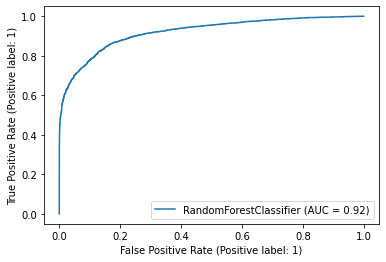

In [119]:
plot_roc_curve(RF_selected, X_test_selected, y_test)

# G) How the predictions can be used in Credit Sesame's product


Since credit sesame is a company that makes consumer credit and loan management simple and automated. The objective of the company is to help the individual manage their credit score, compare the loan providers's rates and find the best strategy to get a loan approved. 

In order to get a loan, the individual often requires to submit the loan application first blindfoldedly. However, if the application gets declined, the credit score would go down significantly which might also affect the individual to apply with the other loan providers which implies the individual might want to know the likelihood of this loan approved before submitting the applicant. 

This model can predict the probability or the likelihood that the individual will get defaulted in credit card's payment and the model can also be used to predict the likelihood of the loan approved based on the attributes of the applicant / individual. 